In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/BERT 电商用户多情绪判断项目

/content/drive/MyDrive/Colab Notebooks/BERT 电商用户多情绪判断项目


In [3]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple tf2-bert

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [4]:
import time

In [5]:
from tf2_bert.models import build_transformer_model
from tf2_bert.tokenizers import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Lambda, Dense, Input, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd

In [6]:
# 周期数
epochs = 5
# 批次大小
batch_size = 32
# 验证集占比
validation_split = 0.2
# 句子长度
seq_len = 256
# 载入数据
data = pd.read_excel('reviews.xlsx')
# 查看数据前 5 行
data.head()

,评论,性价比,产品质量,参加活动,客服物流包装,是否为老顾客,是否会再买,总体评论
0,这款面膜非常的好，真的，特别的水分充足，然后这个面膜材质非常的细腻，对皮肤很好，没有过敏，我...,1,1,0,0,0,0,1
1,面膜很好，挺滋润的，精华很多，买了好几次了，下次有活动再屯点吧！喜欢喜欢喜欢喜欢喜欢喜欢喜欢...,0,1,1,0,1,1,1
2,这款补水保湿的面膜收到货就用了，感觉还不错，吸收挺好，精华液也挺多的，贴完后按摩了一下，吸收...,0,1,0,0,0,0,1
3,美白效果：发觉皮肤越来越水润光泽，肤色也被提亮了，气色变得越来越好，敷上去感觉滑滑的。补水效...,0,1,0,0,-1,0,1
4,什么事也可以让我们变好吗、不会让别人看到别人和她们在背后议论自己喜欢你什么地方好玩不了自己了...,0,0,0,0,0,0,0


In [7]:
# 定义预训练模型路径
model_dir = './chinese_roberta_wwm_ext_L-12_H-768_A-12'
# BERT 参数
config_path = model_dir + '/bert_config.json'
# 保存模型权值参数的文件
checkpoint_path = model_dir + '/bert_model.ckpt'
# 词表
dict_path = model_dir + '/vocab.txt'
# 建立分词器
tokenizer = Tokenizer(dict_path)
# 建立模型，加载权重
bert_model = build_transformer_model(config_path, checkpoint_path)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [8]:
token_ids = []  # 存储每个句子分词后的编号序列
segment_ids = []  # 存储每个句子的分段编号序列
# 循环每个句子
for s in data['评论'].astype(str):
    # 分词并把 token 变成编号
    token_id, segment_id = tokenizer.encode(s, first_length=seq_len)
    token_ids.append(token_id)
    segment_ids.append(segment_id)
token_ids = np.array(token_ids)
segment_ids = np.array(segment_ids)

In [9]:
# 定义标签
def LabelEncoder(y):
    # 增加一个维度
    y = y[:, np.newaxis]
    # 原始标签把-1,0,1 变成 0,1,2  保证标签从 0 开始计数，便于后续进行独热编码
    y = y + 1
    y = y.astype('uint8')  # 转换为 'uint8'，以减少内存占用
    # 转成独热编码
    y = to_categorical(y, num_classes=3)
    return y

In [10]:
# 获取 7 个维度的标签，并把每个维度的标签从-1,0,1 变成 0,1,2
label = [(LabelEncoder(np.array(data[columns]))) for columns in data.columns[1:]]
label = np.array(label)

# token 输入
token_in = Input(shape=(None,))
# segment 输入
segment_in = Input(shape=(None,))
# 使用 BERT 进行特征提取
x = bert_model([token_in, segment_in])
# 每个序列的第一个字符是句子的分类[CLS],该字符对应的 embedding 可以用作分类任务中该序列的总表示
# 说白了就是用句子第一个字符的 embedding 来表示整个句子
# 取出每个句子的第一个字符对应的 embedding
x = Lambda(lambda x: x[:, 0])(x)

In [11]:
# 多任务学习
# 性价比输出层
x0 = Dropout(0.5)(x)
preds0 = Dense(3, activation='softmax', name='out0')(x0)
# 产品质量输出层
x1 = Dropout(0.5)(x)
preds1 = Dense(3, activation='softmax', name='out1')(x1)
# 参加活动输出层
x2 = Dropout(0.5)(x)
preds2 = Dense(3, activation='softmax', name='out2')(x2)
# 客服物流包装输出层
x3 = Dropout(0.5)(x)
preds3 = Dense(3, activation='softmax', name='out3')(x3)
# 是否为老顾客输出层
x4 = Dropout(0.5)(x)
preds4 = Dense(3, activation='softmax', name='out4')(x4)
# 是否会再买输出层
x5 = Dropout(0.5)(x)
preds5 = Dense(3, activation='softmax', name='out5')(x5)
# 总体评论输出层
x6 = Dropout(0.5)(x)
preds6 = Dense(3, activation='softmax', name='out6')(x6)
# 定义模型
model = Model([token_in, segment_in], [preds0, preds1, preds2, preds3, preds4, preds5, preds6])
# 画出模型结构
plot_model(model, show_shapes=True, dpi=300)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 model (Functional)             (None, None, 768)    101677056   ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 768)          0           ['model[0][0]']            

In [12]:
# 定义模型训练的 loss，loss_weights，optimizer
# loss_weights 表示每个任务的权重，可以看情况设置
model.compile(loss={
    'out0': 'categorical_crossentropy',
    'out1': 'categorical_crossentropy',
    'out2': 'categorical_crossentropy',
    'out3': 'categorical_crossentropy',
    'out4': 'categorical_crossentropy',
    'out5': 'categorical_crossentropy',
    'out6': 'categorical_crossentropy'},
    loss_weights={
        'out0': 1.,
        'out1': 1.,
        'out2': 1.,
        'out3': 1.,
        'out4': 1.,
        'out5': 1,
        'out6': 2.},
    optimizer=Adam(1e-5),
    metrics=['accuracy'])

In [13]:
# 保存 val_loss 最低的模型
callbacks = [ModelCheckpoint(filepath='bert_model.h5',
                monitor='val_loss',
                verbose=1,
                save_best_only=True)]

In [ ]:
%%time
# 训练模型
history = model.fit([token_ids, segment_ids], [label[0], label[1], label[2], label[3], label[4], label[5], label[6]],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=validation_split,
          callbacks=callbacks)

Epoch 1/5
250/250 [==============================] - ETA: 0s - loss: 4.4207 - out0_loss: 0.3608 - out1_loss: 0.8598 - out2_loss: 0.2808 - out3_loss: 0.6312 - out4_loss: 0.6134 - out5_loss: 0.3301 - out6_loss: 0.6723 - out0_accuracy: 0.9000 - out1_accuracy: 0.6279 - out2_accuracy: 0.9246 - out3_accuracy: 0.7703 - out4_accuracy: 0.7991 - out5_accuracy: 0.9064 - out6_accuracy: 0.7650
Epoch 1: val_loss improved from inf to 3.25829, saving model to bert_model.h5
250/250 [==============================] - 528s 2s/step - loss: 4.4207 - out0_loss: 0.3608 - out1_loss: 0.8598 - out2_loss: 0.2808 - out3_loss: 0.6312 - out4_loss: 0.6134 - out5_loss: 0.3301 - out6_loss: 0.6723 - out0_accuracy: 0.9000 - out1_accuracy: 0.6279 - out2_accuracy: 0.9246 - out3_accuracy: 0.7703 - out4_accuracy: 0.7991 - out5_accuracy: 0.9064 - out6_accuracy: 0.7650 - val_loss: 3.2583 - val_out0_loss: 0.3208 - val_out1_loss: 0.5651 - val_out2_loss: 0.2841 - val_out3_loss: 0.2007 - val_out4_loss: 0.4896 - val_out5_loss: 0.2

In [14]:
import matplotlib.pyplot as plt

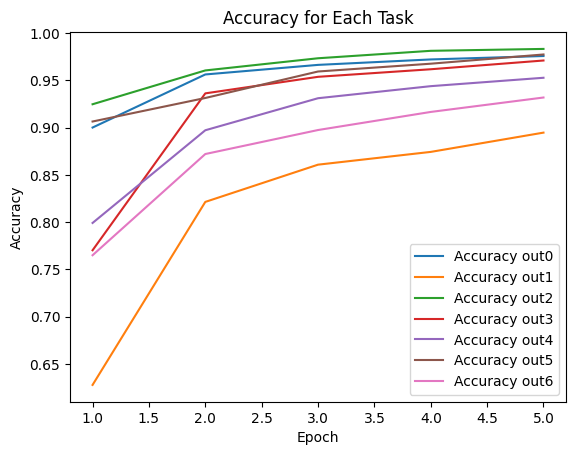

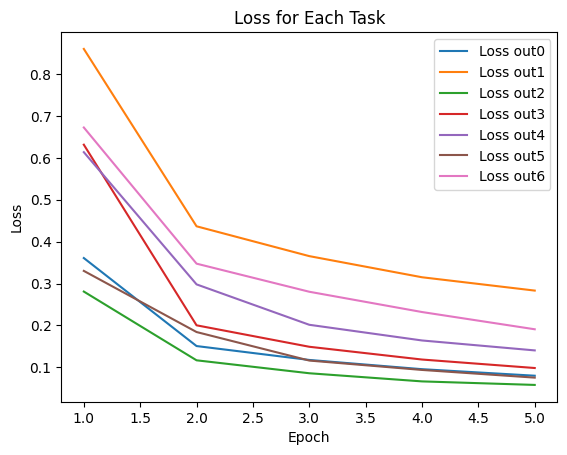

In [17]:
# 获取训练过程中的准确率和损失值
accuracy_out0 = history.history['out0_accuracy']
accuracy_out1 = history.history['out1_accuracy']
accuracy_out2 = history.history['out2_accuracy']
accuracy_out3 = history.history['out3_accuracy']
accuracy_out4 = history.history['out4_accuracy']
accuracy_out5 = history.history['out5_accuracy']
accuracy_out6 = history.history['out6_accuracy']


loss_out0 = history.history['out0_loss']
loss_out1 = history.history['out1_loss']
loss_out2 = history.history['out2_loss']
loss_out3 = history.history['out3_loss']
loss_out4 = history.history['out4_loss']
loss_out5 = history.history['out5_loss']
loss_out6 = history.history['out6_loss']

# 创建 epochs 列表，用于横坐标
epochs = range(1, len(accuracy_out0) + 1)

# 绘制七个任务的准确率曲线
plt.plot(epochs, accuracy_out0, label='Accuracy out0')
plt.plot(epochs, accuracy_out1, label='Accuracy out1')
plt.plot(epochs, accuracy_out2, label='Accuracy out2')
plt.plot(epochs, accuracy_out3, label='Accuracy out3')
plt.plot(epochs, accuracy_out4, label='Accuracy out4')
plt.plot(epochs, accuracy_out5, label='Accuracy out5')
plt.plot(epochs, accuracy_out6, label='Accuracy out6')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for Each Task')
plt.show()

# 绘制七个任务的损失值曲线
plt.plot(epochs, loss_out0, label='Loss out0')
plt.plot(epochs, loss_out1, label='Loss out1')
plt.plot(epochs, loss_out2, label='Loss out2')
plt.plot(epochs, loss_out3, label='Loss out3')
plt.plot(epochs, loss_out4, label='Loss out4')
plt.plot(epochs, loss_out5, label='Loss out5')
plt.plot(epochs, loss_out6, label='Loss out6')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss for Each Task')
plt.show()

In [15]:
# 载入模型
model = load_model('bert_model.h5')
# 词表路径
dict_path = './chinese_roberta_wwm_ext_L-12_H-768_A-12'+'/vocab.txt'
# 建立分词器
tokenizer = Tokenizer(dict_path)

In [16]:
# 预测函数
def predict(text):
  # 分词并把 token 变成编号，句子长度需要与模型训练时一致
  token_ids, segment_ids = tokenizer.encode(text, first_length=256)
  # 增加一个维度表示批次大小为 1
  token_ids = np.expand_dims(token_ids,axis=0)
  # 增加一个维度表示批次大小为 1
  segment_ids = np.expand_dims(segment_ids,axis=0)
  # 模型预测
  pre = model.predict([token_ids, segment_ids])
  # 去掉一个没用的维度
  pre = np.array(pre).reshape((7,3))
  # 获得可能性最大的预测结果
  pre = np.argmax(pre,axis=1)
  comment = ''
  if(pre[0]==0):
    comment += '性价比差,'
  elif(pre[0]==1):
    comment += '-,'
  elif(pre[0]==2):
    comment += '性价比好,'
  if(pre[1]==0):
    comment += '质量差,'
  elif(pre[1]==1):
    comment += '-,'
  elif(pre[1]==2):
    comment += '质量好,'
  if(pre[2]==0):
    comment += '希望有活动,'
  elif(pre[2]==1):
    comment += '-,'
  elif(pre[2]==2):
    comment += '参加了活动,'
  if(pre[3]==0):
    comment += '客服物流包装差,'
  elif(pre[3]==1):
    comment += '-,'
  elif(pre[3]==2):
    comment += '客服物流包装好,'
  if(pre[4]==0):
    comment += '新用户,'
  elif(pre[4]==1):
    comment += '-,'
  elif(pre[4]==2):
    comment += '老用户,'
  if(pre[5]==0):
    comment += '不会再买,'
  elif(pre[5]==1):
    comment += '-,'
  elif(pre[5]==2):
    comment += '会继续购买,'
  if(pre[6]==0):
    comment += '差评'
  elif(pre[6]==1):
    comment += '中评'
  elif(pre[6]==2):
    comment += '好评'
  return pre,comment

In [17]:
pre,comment = predict("还没用，不知道怎么样")
print('pre:',pre)
print('comment:',comment)

1/1 [==============================] - 7s 7s/step
pre: [1 1 1 1 1 1 1]
comment: -,-,-,-,-,-,中评


In [18]:
pre,comment = predict("质量不错，还会再来，价格优惠")
print('pre:',pre)
print('comment:',comment)

1/1 [==============================] - 0s 100ms/step
pre: [2 2 1 1 1 2 2]
comment: 性价比好,质量好,-,-,-,会继续购买,好评


In [19]:
pre,comment = predict("好用不贵物美价廉，用后皮肤水水的非常不错")
print('pre:',pre)
print('comment:',comment)

1/1 [==============================] - 0s 71ms/step
pre: [2 2 1 1 1 1 2]
comment: 性价比好,质量好,-,-,-,-,好评
